# GoFundMe data preparation and EDA

The following set of commands is an outline of the data preparation for the GoFundMe dataset. The imported `csv` file is the raw data that was mined from the GoFundMe website, where the only processing conducted was the tokenization of the campaign description under the `story_tokens` column. Further data processing is needed in order to perform some exploratory data analysis (EDA).

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('gofund_data.csv')

## Processing raised and target fields

In order to perform any kind of calculation, the raw string that was scraped needs to undergo some preparation. In this case, the currency symbols that came with the dollar amounts for `raised` and `target` columns need to be
removed, before they can be converted into the appropriate data type.

`df[['raised', 'target']].head()`
```
raised	target
0	$695	$1,000
1	$695	$300
2	$690	$1,000
3	$690	$500
4	$690	$1,000
```

In [3]:
## Remove currency symbols and replace with ''
df['raised'] = df['raised'].str.replace('€', '')
df['target'] = df['target'].str.replace('€', '')
df['raised'] = df['raised'].str.replace('$', '')
df['target'] = df['target'].str.replace('$', '')
df['raised'] = df['raised'].str.replace(',', '')
df['target'] = df['target'].str.replace(',', '')

The next step is to convert the `dtype` from `object` into `int`. Here is output before being converted. Notice the difference in `dtype`.


```
Unnamed: 0        int64
url_index        object
title            object
raised           object
target           object
m_campaign       object
created_date     object
donors          float64
shares          float64
followers       float64
scrape_date      object
c_story          object
story_tokens     object
dtype: object
```

In [4]:
# Convert dtypes
df['raised'] = df['raised'].astype(int)
df['target'] = df['target'].astype(int)
df['scrape_date'] = pd.to_datetime(df['scrape_date'])

## Clean created_date field

The `created_date` field needs some processing prior to being converted into `datetime` objects as well. Notice how it is encoded as `dtype(object)`, compared to the `scrape_date` field. This is because new campaigns relative to the `scrape_date` were labelled as being `"Created {x} days ago"` on the GoFundMe website, whereas the `scrape_date` was more straightforward to convert into `datetime` format.

```
6030            2020-08-14
5631            2020-08-14
2964    Created 2 days ago
4106    Created 2 days ago
3011    Created 2 days ago
Name: created_date, dtype: object
```

In [5]:
# Regex pattern to find the beginning of a string that is a non-digit
pattern = r'(^[\D])'

# Placeholder for lists to be used later.
days_ago = []
days_index = []
days_int = []

df_tmp = df['created_date'].str.match(pattern)

### Function to extract days

In [6]:
def update_created_date():
    """Cleaning of 'Created x days ago' """
    
    for index, value in df_tmp.items():
        if value == True:
            days_index.append(index) # Append indices for rows that returned True

    for i in days_index:
        # Split "Created..." string in order to grab just the number of days        
        split_date = df['created_date'].loc[i].split(" ")
        days_int.append(int(split_date[1])) # Append just the number of days to list


update_created_date()

Now, the numbers from `"Created {x} days ago"` have been extracted and added to a list which can be used to calculate the actual date the campaign was created.

```
Extracted number list: 
[2, 2, 7, 7, 6, 3, 4, 7, 2, 3, 7, 7, 7, 3, 4, 4, 3, 4] 

List of indices associated with the row: 
[2964, 3011, 3945, 3946, 3967, 4058, 4076, 4100, 4106, 4155, 4185, 4216, 4335, 4337, 6862, 6864, 6907, 6989]
```

In [7]:
df.loc[days_index, 'created_date'] = days_int
df.loc[days_index, 'created_date']

2964    2
3011    2
3945    7
3946    7
3967    6
4058    3
4076    4
4100    7
4106    2
4155    3
4185    7
4216    7
4335    7
4337    3
6862    4
6864    4
6907    3
6989    4
Name: created_date, dtype: object

### Convert date fields into proper datetime objects

With the `created_date` field properly formatted, we can now calculate the actual date the campaign was launched on the website, and assign that to the specific element.

In [8]:
from datetime import timedelta

# Set SettingWithCopyWarning! to None
pd.set_option('mode.chained_assignment', None)

In [9]:
# subtract days_ago from scrape_date
date_list = []
for i in days_index:
    df['created_date'].loc[i] = df['scrape_date'][i] - timedelta(days=int(df['created_date'][i]))

In [10]:
df['created_date'] = pd.to_datetime(df['created_date'])

We now have a properly formatted date column where EDA can be applied!

```
7060   2020-08-13
7034   2020-08-13
6963   2020-08-13
3945   2020-08-14
4100   2020-08-14
4335   2020-08-14
3967   2020-08-15
6989   2020-08-17
6862   2020-08-17
4155   2020-08-18
4058   2020-08-18
6907   2020-08-18
2964   2020-08-19
4106   2020-08-19
3011   2020-08-19
Name: created_date, dtype: datetime64[ns]

Unnamed: 0               int64
url_index               object
title                   object
raised                   int64
target                   int64
m_campaign              object
created_date    datetime64[ns]
donors                 float64
shares                 float64
followers              float64
scrape_date     datetime64[ns]
c_story                 object
story_tokens            object
dtype: object
```

In [11]:
df.head(3)

,Unnamed: 0,url_index,title,raised,target,m_campaign,created_date,donors,shares,followers,scrape_date,c_story,story_tokens
0,0,the-front-steps-project-yyc\n,The Front Steps Project YYC,695,1000,animal-fundraiser,2020-03-27,16.0,21.0,14.0,2020-08-21,"It feels like the world has stopped, doesn’t i...","['It feels like the world has stopped, doesn’t..."
1,1,torchlight-covid19-fund-for-joseph-brant-hospi...,Torchlight COVID-19 Fund for Joseph Brant Hosp...,695,300,medical-fundraiser,2020-05-04,10.0,0.0,10.0,2020-08-21,Torchlight is a community-based gaming store l...,['Torchlight is a community-based gaming store...
2,2,actions-against-abuse\n,Actions Against Abuse,690,1000,volunteer-fundraiser,2020-07-04,28.0,70.0,27.0,2020-08-21,Want to join me and my team in making a differ...,['Want to join me and my team in making a diff...


## Descriptive Statistics for the GoFundMe dataset

Now that all the variable have been properly formatted, we can perform some exploratory data analysis on the dataset!
Interestingly enough, we can actually say that almost all followers were actually donating to their chosen campaign!

In [12]:
df.describe()

,Unnamed: 0,raised,target,donors,shares,followers
count,7077.00000,7.077000e+03,7.077000e+03,5978.000000,5978.000000,5978.000000
mean,3538.00000,2.023595e+05,2.167393e+05,90.131984,173.207762,90.368183
std,2043.09826,1.205474e+07,1.205510e+07,128.896606,224.728899,130.221997
min,0.00000,1.000000e+00,1.000000e+00,1.000000,0.000000,1.000000
25%,1769.00000,1.000000e+03,2.000000e+03,18.000000,14.000000,18.000000
50%,3538.00000,2.690000e+03,5.000000e+03,39.000000,77.000000,39.000000
75%,5307.00000,8.950000e+03,1.500000e+04,105.000000,247.000000,105.000000
max,7076.00000,1.000000e+09,1.000000e+09,968.000000,999.000000,972.000000


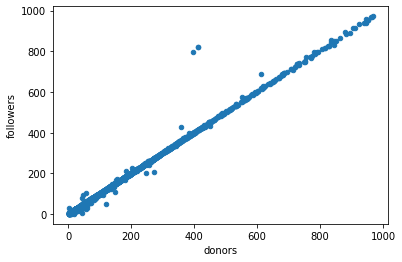

In [13]:
df.plot.scatter(x='donors', y='followers')

### Amount Raised by Category

Combining the total amount raised for each category, we then sort according to the category with the highest dollar amount raised so far...

In [14]:
df_rc = pd.melt(df, id_vars=['m_campaign'], value_vars='raised', value_name='Amount Raised', var_name='Category')
df_rc = df_rc.groupby('m_campaign').sum()
df_rc.rename_axis('Category', inplace=True)
pd.options.display.float_format = '{:,.2f}'.format
df_rc = df_rc.sort_values('Amount Raised', ascending=False)
df_rc

,Amount Raised
Category,
competition-fundraiser,1001113846
newlywed-fundraiser,266540890
travel-fundraiser,97447367
medical-fundraiser,18654746
emergency-fundraiser,11709363
memorial-fundraiser,11515473
community-fundraiser,6693148
family-fundraiser,4938286
animal-fundraiser,2492360


And we can see how the data is skewed by the top 5 campaign categories below.

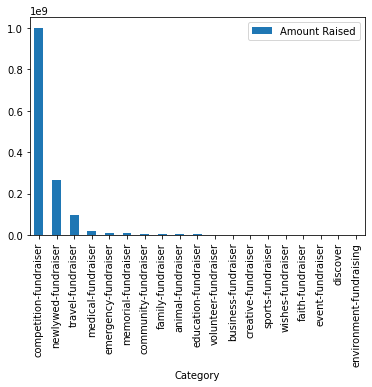

In [15]:
df_rc.plot(kind='bar')

### Number of Campaigns per Category

It's easy to hypothesize that campaign categories with more number of followers would yield higher dollar amounts, so let's test that using some basic frequency counts. We can summarize this by showing the number of individual campaigns per category.

In [16]:
df_cat = df[['m_campaign', 'title']]
df_cat = df_cat.groupby('m_campaign').count()
df_cat.drop(index='discover', inplace=True)
df_cat.rename_axis('Category', inplace=True)
df_cat = df_cat.rename(columns={'title': 'Number of Campaigns'})
df_cat = df_cat.sort_values(by='Number of Campaigns', ascending=False)
df_cat

,Number of Campaigns
Category,
medical-fundraiser,584
community-fundraiser,574
volunteer-fundraiser,458
emergency-fundraiser,450
family-fundraiser,437
faith-fundraiser,434
education-fundraiser,432
creative-fundraiser,427
animal-fundraiser,410


#### Looking at total dollar amount raised versus total number of campaigns

Remember our top 5 campaign category in terms of dollar amount raised...
```
competition-fundraiser	1001113846
newlywed-fundraiser	266540890
travel-fundraiser	97447367
medical-fundraiser	18654746
emergency-fundraiser	11709363
```
As it turned out, we have a slightly different picture when the data it pitted against the number of campaigns *within* each category...

```
medical-fundraiser	584
community-fundraiser	574
volunteer-fundraiser	458
emergency-fundraiser	450
family-fundraiser	437
```

`medical` and `emergency` fundraisers are in both summaries. Interestingly enough, `competition`fundraisers end up at the far end of our plot of total number of campaigns. Objectively, people who donate to competitive causes give higher dollar amounts based on the comparison between the total amount raised versus total number of campaigns in each category.

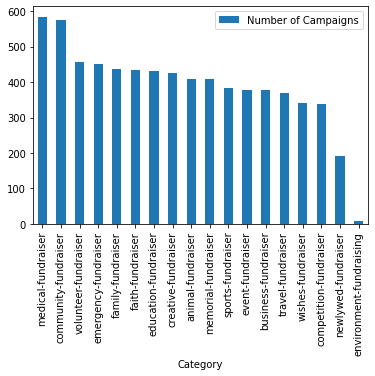

In [17]:
df_cat.plot.bar()

### Visualize Amount Raised vs Number of Donors

In [18]:
df_rv = pd.DataFrame(df[['m_campaign', 'donors', 'raised']])
df_rv = df_rv.groupby('m_campaign').median()
df_rv.drop(index='discover', inplace=True)
df_rv.sort_values(by='raised', ascending=False)

,donors,raised
m_campaign,,
medical-fundraiser,167.00,"25,475.00"
memorial-fundraiser,172.00,"20,062.50"
emergency-fundraiser,151.00,"17,444.50"
family-fundraiser,64.00,"6,265.00"
community-fundraiser,49.00,"4,650.50"
animal-fundraiser,56.00,"3,605.00"
education-fundraiser,31.00,"3,045.00"
volunteer-fundraiser,27.00,"2,240.00"
creative-fundraiser,24.00,"2,010.00"
